# What is this about?

Hi! Within this notebook I started to teach myself the theory and practice of Bayesian inference and MCMC sampling by means of a toy problem. In case you stumble across an error or other ways to improve this notebook (not unlikely!), please let know. Thanks! :-)

A big thanks goes out to Josh Fass for excellent discussions and offering expertise on this topic!

#### Before we dive in...
... please execute the two cells below. It will install some packages from conda and load modules and classes relevant to this notebook. For implementation details, have a look at fourier_series and MH_sampler in mcmc_sampler.py

In [1]:
!conda install --yes -c conda-forge matplotlib numpy scipy dask tqdm

Solving environment: done

# All requested packages already installed.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.distributed import Client
from mcmc_sampler import fourier_series, MH_sampler

### You may change n_workers to whatever number of 
### processors you'd like to use here
client = Client(threads_per_worker=1, n_workers=5)

# Sampling parameters using Bayesian inference

## 1.) A toy problem: A Fourier series of unknown length
Fourier series (a cosine series) are used by most molecular machanics force fields in order to model torsion potentials. The general form of a torsion potential includes force constants $V_n$ (i.e. an amplitude in this context) and the phase angles $\delta_n$ as paramters:

\begin{equation}\label{eq:TorsionSeries}
V_{tors}(\phi) = \sum_{n} {1 \over 2 } V_n (1 + cos(n\phi + \delta_n))
\end{equation}

For a given torsion around a bond B-C, the number of terms in this series depends on the symmetry of the molecular fragment A-B-C-D. Also, it is possible that some terms have a $V_n$ of zero. In the context of this notebook, we will use a simplified version of the equation above and just assume a single set of parameters $ \theta_N: \{a_1, a_2, ..., a_N\}$:

\begin{equation}\label{eq:CosineSeries}
f(x)_{N} = \sum_{n}^{N} a_n cos(nx)
\end{equation}

We will assume that there is some actual (true) process that generates data, which we can observe, following eq. \ref{eq:CosineSeries}. However, we do not know how exactly this process looks like (i.e. we do not know the precise parameters $a_n$ in eq. \ref{eq:CosineSeries}), we just know that it must be a process following eq. \ref{eq:CosineSeries}. The objective of this notebook is the exploration of ways to use Bayesian statistics to find out about the nature of the true process. That means, we want to know the parameters $\theta_N$ and $N$ in eq. \ref{eq:CosineSeries} of the true process. However, we will only be able to obtain a limited number of samples (observations) from that true process. To make things worse, we cannot observe these samples without noise and we do not know how large this noise is. Since the data is sparse and also noisy, it is much more useful to know the distribution of parameters $\theta_N$ and $N$ given the data generated from the true process, rather than estimating the precise parameter values. This setting is ideal for Bayesian statistics.

## 2.) Using Bayesian Statistics for Model Inference
In Bayesian inference, we are searching for the posterior distribution of the parameters, $p(\theta_N|Y)$, i.e. we are interested in the parameter distribution that generated the observed data $Y$. It is important to realize that we are not interested in the true parameter values $\hat{\theta}_N$, but really the distribution of these parameter values under the observed data. Since we are also interested in quantifying the noise contained in the true process, we want to include an unknown noise parameter into our considerations. We will assume that the true process contains some noise following a Gaussian distribution, so that $y_i = f(x_i) + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2)$, thus we will include $\sigma^2$ as an unknown parameter.

The posterior distribution for a given model $\mathcal{M}_k: f(x)_k$, with $k>0$ is defined as follows:

\begin{equation}\label{eq:BayesEquation}
p(\theta_k, \sigma^2|Y) = {{p(Y|\theta_k,\sigma^2) p(\theta_k) p(\sigma^2)} \over p(Y)} \propto p(Y|\theta_k,\sigma^2) p(\theta_k) p(\sigma^2)
\end{equation}

- $p(Y)$: Evidence
- $p(Y|\theta_k)$: Likelihood
- $p(\theta_k)$: Prior on $\theta_k$
- $p(\sigma^2)$: Prior on $\sigma^2$
- $p(\theta_k, \sigma^2|Y)$: Posterior

### Evidence
The evidence $p(Y)$ can be treated as a normalizing constant as long as one is only interested in the posterior distribution of a particular model $\theta_k$ (i.e. with fixed $N$). In that case, the posterior distribution is only known up to this normalizing constant, which is fine. However, if one wants to compare different models ${\mathcal{M}_k}$ (and we want to do that at a later point!), it will become important to not ignore that normalizing constant.

### Likelihood
The likelihood is a measure for the probability that the given data can be observed under the model parameters $\theta_k$ (it is not a likelihood though!). We will assume that each observed realization $Y_i$ is drawn from a Gaussian distribution (see above). However, we do not know the exact parameters of that distribution. Our task is to find these parameters, $(\mu_i, \sigma^2)$ during the Bayesian inference. The parameters $(\mu_i, \sigma^2)$ will be informed by our choice of $\theta_k$, i.e.

\begin{equation}\label{eq:LikelihoodMu}
\mu_i(\theta_k) = f(x_i)_{\theta_k}
\end{equation}

\begin{equation}\label{eq:LikelihoodSigma}
Y_i \sim \mathcal{N}(\mu_i,\sigma^2)
\end{equation}

\begin{equation}\label{eq:Likelihood}
p(Y|\theta,\sigma) = \prod_i {1 \over \sqrt{2 \pi \sigma^2}} exp\big( { -(Y_i-\mu_i)^2 \over 2 \sigma^2}\big)
\end{equation}

### The prior

The prior probabilities $p(\theta_k)$ and $p(\sigma^2)$ reflect our prior knowledge of the parameter vector $\theta_k$ and the noise parameter $\sigma^2$. In case we already know that the parameter is likely to be in specific range or if certain parameter values are not resonable (e.g. in a physics-based model) then the prior probability can reflect that knowledge. Other than that, one can also be rather objective and assign equal prior probility to all realizations of $\theta_k$. The latter is exactly what we will do in the following. We assign non-zero probability to all parameters on the interval $[b,c]$ and zero probability otherwise:

\[
    p(a_i) = 
\begin{cases}
    (c-b)^{-1},& \text{if } b < a_i < c \\
    0, & \text{otherwise}
\end{cases}
\]

\begin{equation}\label{eq:PriorCombined}
p(\theta_k) = \prod_i^k p(a_i)
\end{equation}


The prior over the noise parameter will be an inverse gamma distribution, i.e. $\sigma \sim \mathcal{IG}(\alpha,\beta)$, where $\beta=1$ and $\alpha$ is a hyperparameter that we have to specify later:

\begin{equation}\label{eq:InverseGamma}
p_\alpha(\sigma) = {1 \over \Gamma(\alpha)} \sigma ^{-\alpha-1} exp\big(-{1 \over \sigma}\big)
\end{equation}

### The posterior

The posterior distribution, see eq. \ref{eq:BayesEquation}, in most cases cannot be solved analytically and must be sampled using special algorithms. That means, instead of computing the posterior directly, we will draw samples from the posterior distribution, which should converge to the true posterior distribution if we use an infinite amount of sampling. The sampling algorithm that we are going to use is called Metropolis-Hastings and is probably one of the most common algorithms from the Markov Chain Monte Carlo family. It will be explained in the following section.

## 3.) Metropolis-Hastings Algorithm

The original aim of this algorithm is to construct a Markov Chain that has the same distribution as the desired target distribution (in our case the posterior probability distribution). A Markov Chain describes a "chain" (i.e. a sequence) of states (i.e. realizations of the random variable, here $\theta$), in which the probability to realize the current state only depends on the previous state. This is called the Markov property. Assuming that the states are living in a finite state space, the Markov property is (we will stick to $\theta$ being our random variable):

\begin{equation}\label{eq:MarkovProperty}
p(\theta^{(t+1)} = \theta' | \theta^{(t)} = \theta, ... , \theta^{(0)} = z ) =
p(\theta^{(t+1)} = \theta' | \theta^{(t)} = \theta )
\end{equation}

Here, $\theta^{(t+1)}$ is the current state of the Markov Chain and $\theta^{(0)}, \theta^{(1)}, ... , \theta^{(t)}$ are all previous states. Another way of looking at the Markov property is to realize that these are transition functions, that is 

\begin{equation}\label{eq:TransitionFunction}
A(\theta, \theta') =  p(\theta^{(t+1)} = \theta' | \theta^{(t)} = \theta )
\end{equation}

If we now assume that the Markov Chain is reversible (i.e. if we get the same result irrespective of running it backwards or forwards), we can apply the detailed balance condition:

\begin{equation}\label{eq:DetailedBalance}
p(\theta|Y) A(\theta, \theta') = p(\theta'|Y) A(\theta', \theta)
\end{equation}

Integrating out $\theta$ results in

\begin{equation}\label{eq:DetailedBalanceIntegrated}
\int d\theta p(\theta|Y) A(\theta, \theta') = p(\theta'|Y)
\end{equation}

Eq. \ref{eq:DetailedBalanceIntegrated} is an important result, since it shows that sampling from the target distribution $p(\theta'|Y)$ is invariant with respect to the transition function $A(\cdot ,y)$ as long as we ensure that we are markovian and reversible! This is where the Metropolis-Hasting Algorithm comes into the game. Metropolis suggested to use the following algorithm (again we use $\theta$ as our random variable):

The Markov Chain is initialized at state $\theta^{(t)} = \theta^{(0)}$
\begin{enumerate}
\item Propose a new state $\theta'$ from a proposal distribution $q(\theta^{(t)}, \theta')$
\item Evaluate the posterior distribution (the target distribution), $p(\theta',Y)$ at the proposed state.
Then, calculate the acceptance probability $\alpha(\theta^{(t)}, \theta')$ for this transition:

\begin{equation}\label{eq:AcceptanceProbability}
\alpha(\theta^{(t)}, \theta') = min\Big(1, {p(\theta'|Y) q(\theta',\theta^{(t)})
\over p(\theta^{(t)}|Y) q(\theta^{(t)},\theta')} \Big)
\end{equation}

Draw a random number from a uniform distribution $u \propto unif(0,1)$. Update the state $t+1$ of the chain according to

\[
    \theta^{(t+1)} = 
\begin{cases}
    \theta',& \text{if } u \leq \alpha(\theta^{(t)}, \theta')\\
    \theta^{(t)}, & \text{otherwise}
\end{cases}
\]

\end{enumerate}

The acceptance probability $\alpha$ (see eq. \ref{eq:AcceptanceProbability}) in the MH algorithm is related to the Markov property (see eq. \ref{eq:DetailedBalance}) through the relation $\alpha(\theta^{(t)}, \theta') = { A(\theta, \theta') \over q(\theta, \theta')}$. Thus, one can rewrite the acceptance probability as

\begin{equation}\label{eq:AcceptanceProbability_Markov}
p(\theta|Y) A(\theta, \theta') = min \Big( p(\theta|Y) q(\theta, \theta'), p(\theta'|Y) q(\theta', \theta) \Big)
\end{equation}

This algorithm allows Markovian sampling using a Markov Chain Monte Carlo strategy (MCMC). This particular algorithm is maybe not the most efficient one, but it is (A) easy to implement and (B) sufficiently efficient for low dimensional problems like the ones we are dealing with in this example.

### Reading

* "Monte Carlo Strategies in Scientific Computing", Jun S. Liu

## 4.) Let's Generate Some Data!

Next, we will generate data $Y$ from a process that follows eq. \ref{eq:CosineSeries} and has three non-zero terms, $a_1, a_2, a_3$. Also this process contains noise from a zero-mean Gaussian distribution. The parameters are

$a_1  = 5.10, a_2 = 0.13, a_3 = 3.24, \sigma^2 = 0.3$

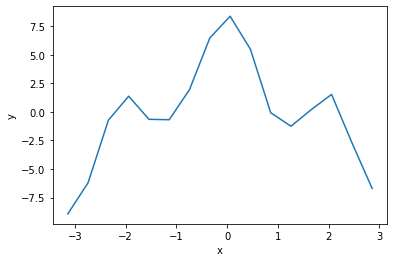

In [3]:
### Parameters
p = np.array([5.10, 0.13, 3.24])

### You may either reuse these x,y values, which should get you close
### to the outcome of my calculations or just generate your own data.
x = np.array([-3.14159265, -2.74159265, -2.34159265, -1.94159265, -1.54159265, -1.14159265,
     -0.74159265, -0.34159265,  0.05840735,  0.45840735,  0.85840735,  1.25840735,
      1.65840735,  2.05840735,  2.45840735,  2.85840735])

y = np.array([-8.92247276, -6.19605699, -0.7293233,   1.37097261, -0.65165646, -0.68584825,
      1.95369845,  6.46307948,  8.36168418,  5.47697352, -0.07383572, -1.2556803,
      0.19878288,  1.5263483,  -2.68581297, -6.69607447])

### If you want to generate your own data, 
### uncomment the following lines. The generated
### data will contain a zero-mean noise term.
#x = np.arange(-np.pi,np.pi,0.4)
#y = fourier_series(x,p) + np.random.normal(0,np.sqrt(0.3),size=x.size)

plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 5.) Model Inference Using within-model MH Sampling

In the first step of this notebook tutorial, we want to sample the parameter posterior distribution from each model $\mathcal{M}_k$ individually using the MH algorithm . Since we will sample $\theta_k$ for each model seperately and the individual models do not know about each other, we call this approach within-model sampling, i.e. we sample each set of parameters from its own distribution $\theta_k \sim p(\theta_k | k, Y)$.

### MC Propagation and Hyperparameters

Some parameters must be set by us in advance. These hyperparameters are the step width $w$ and the shape parameter $\alpha$ of the inverse gamma distribution (see eq. \ref{eq:InverseGamma}). A new state $(\theta_k, \sigma^2)'$ is proposed by adding a random perturbation to the current state of the Markov Chain. This perturbation follows a zero-mean normal distribution with standard deviation $s$ (this is our "step width"). By using a normal distribution we also guarantee symmetric moves. Specificually for the vector components $a_i$

\begin{equation}\label{eq:Propagation}
a_i' = a_i^{(t)} + w_i
\end{equation}

\begin{equation*}
w_i \sim \mathcal{N}(0, s)
\end{equation*}

And we will do the same thing for the proposal of the variance ${\sigma^2}'$, however we will propose on ${\sigma}'$ in order to always have ${\sigma^2}' > 0$. It is generally encouraged to play around with the these hyperparameters. A nice lesson is to vary the step width $s$ and see how the number of accepted moves is going to vary!

### Start the Sampling!

In order to start the sampling we will need to guess some initial parameters for each model. Of course we don't set it to the correct parameters, instead we use the correct parameters and add considerable amount of noise. Ideally, one would repeat these runs with different initial parameter settings in order to confirm that they actually all converge to the same stationary distribution (remember the Markov Property eq. \ref{eq:MarkovProperty} ?). However, in our case we only carry out a single (but long) run for each model.

Now execute the below code block in order start the sampling. This should take about 15 minutes on a desktop computer, if you initialized at least 5 dask workers (see code block in the very beginning of this notebook!). We need several sampling steps in order to get converged results for the calculation of the evidence at a later stage. A total of 100000 steps per run seems to be reliable here.

In [4]:
### This is our step width 's'
step_width  = 0.05
### This is our prior width for the inverse gamma distribution
sigma_width = 2.0
### This is our reference that defines the boundaries on 
### parameter prior.
p_ref       = np.array([0., 6])
### This is the initial value of the standard deviation.
### We will use the same value for each MH run
sigma0      = 0.1

### This is a list of initial parameter vectors. They are of
### varying length, going from 2 up to 6 parameters.
p0_list = [p[:2] + 1.0 * np.random.random(2), 
           p     + 1.0 * np.random.random(p.shape),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0])),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0, 1.0])),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0, 1.0, 1.0]))
           ]

### Let's loop over some models and see how that
### changes the Bayesian quantities and the parameters
lazy_results = list()
def worker(sampler, *args):
    sampler.run(*args)
    return sampler
for p0 in p0_list:
    sampler = MH_sampler(step_width,
                         sigma_width,
                         p_ref,
                         x,
                         y,
                         fourier_series)
    
    lazy_result = dask.delayed(worker)(sampler, p0, sigma0, 100000)
    lazy_results.append(lazy_result)
sampler_list = list(dask.compute(*lazy_results))

### Understanding the Results of the MH Sampling

We started with parameters that were somewhat different from the ones of the true model (c.f. compare variables p0_list and p). Therefore we get low posterior probabilities in the beginning of the sampling. It is customary to discard these samples ('burn in') and only keep those that a drawn from the stationary posterior. In our case, we don't really have to do it, since we have lots of sampling, however we do it anyway since it is common practice. We will identify the first 2000 steps as the 'burn in' period, after this period the $-ln(posterior)$ over all MCMC steps (see below) seems to be stable (note the different scale of the individual y-axis).

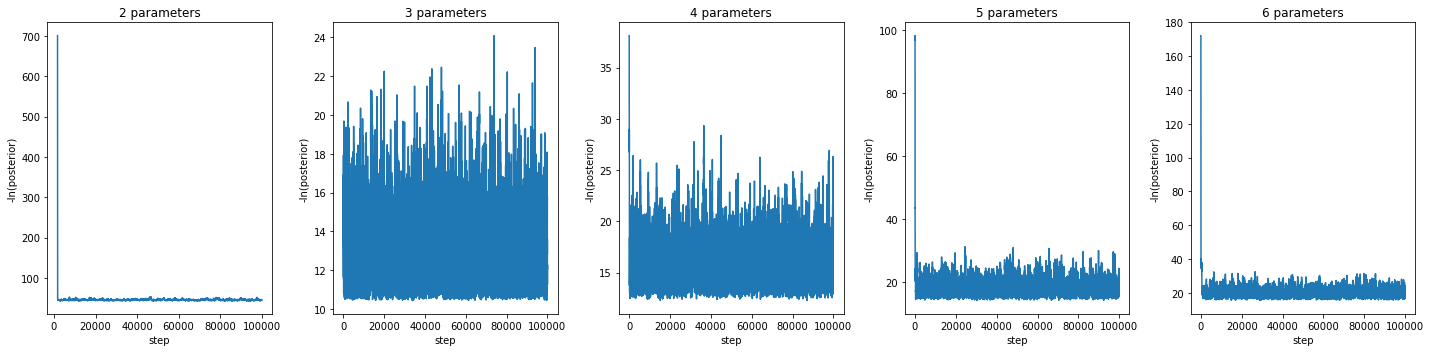

In [5]:
fig_traj, ax_traj = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    sampler          = sampler_list[i]
    accept_posterior = np.array(sampler.accept_posterior)[10:]
    ax_traj[i].plot(-np.log(accept_posterior))
    ax_traj[i].set_title(f"{i+2} parameters")
    ax_traj[i].set_ylabel("-ln(posterior)")
    ax_traj[i].set_xlabel("step")
fig_traj.tight_layout()
fig_traj.show()

### Parameter distribution

Next, let's look at the distribution of the parameters (see below, the dashed lines indicate the true values). We find that the MH sampler recovers the true parameters. For $\mathcal{M}_2$ we find a broad distribution of both parameters $a_1$ and $a_2$, this is not surprising since it is too simple a model to be able to capture the true data. The somewhat broadend parameter distribution indicates that a large number of parameter realizations is possible given data, since all of these realizations result in poor posterior probability. The correct model,  $\mathcal{M}_3$ on the other hand shows nicely distributed parameters, matching the true ones quite nicely. The other 3 models, $\mathcal{M}_4$, $\mathcal{M}_5$ and $\mathcal{M}_6$, show similar distributions but parameters $a_4$, $a_5$ and $a_6$ are sampled close to zero in order cope with the fact that the true model does not need those parameters.

Also see the overview of all the models in the graphs of the second row below (the dashed line indicates the true model). One sees that no solution of $\mathcal{M}_2$ is actually coming close to the true model.

The below codeblock should take about 10 minute to finish.

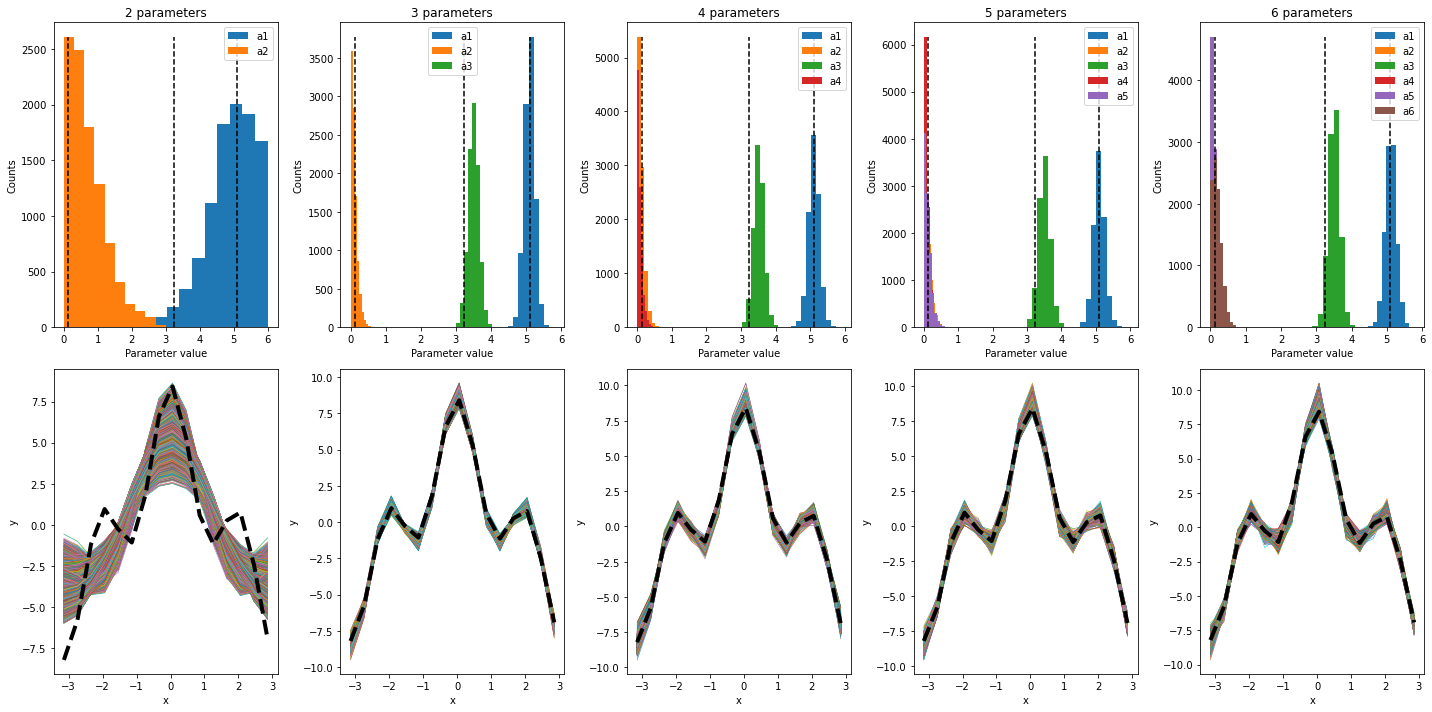

In [6]:
burn_in = 2000

fig_parms, ax_parms = plt.subplots(2,5, figsize=(20,10))
for i in range(5):
    sampler      = sampler_list[i]
    accept_theta = sampler.accept_theta[burn_in::10]
    maxbins      = 0.
    for d in range(accept_theta.shape[1]):
        n, bins, patches = ax_parms[0][i].hist(accept_theta[:,d], label=f"a{d+1}")
        if np.max(n)>maxbins:
            maxbins = np.max(n)
    ax_parms[0][i].vlines(x=p[0], ymin=0, ymax=maxbins, linestyles="--")
    ax_parms[0][i].vlines(x=p[1], ymin=0, ymax=maxbins, linestyles="--")
    ax_parms[0][i].vlines(x=p[2], ymin=0, ymax=maxbins, linestyles="--")
    ax_parms[0][i].set_title(f"{i+2} parameters")
    ax_parms[0][i].set_ylabel("Counts")
    ax_parms[0][i].set_xlabel("Parameter value")
    ax_parms[0][i].legend()
    
    for theta in accept_theta:
        ax_parms[1][i].plot(x, fourier_series(x, theta), linewidth=0.5)
    ax_parms[1][i].set_ylabel("y")
    ax_parms[1][i].set_xlabel("x")
    
for i in range(5):
    ax_parms[1][i].plot(x, fourier_series(x, p), 
                        color="black", linestyle="--", 
                        linewidth=4)    
    
fig_parms.tight_layout()
fig_parms.show()

### Model evidence
The logical conclusion up until now would be (assuming we do not know the true model), that all but $\mathcal(M)_2$ are possible. If we apply the rule of Occam's razor, we would just assume that $\mathcal(M)_3$ is correct, since it is the most simplistic one among the remaining 4 models. However, the definition of simplistic is not quite objective and generally is not merely based on the number of parameters in a given model. In the next steps, we want to find out the true model and hopefully fulfilling Occam's at the same time using a less subjective approach. In order to do so, we want to recall the normalizing constant $p(Y)$ introduced in the beginning. This normalazing constant, also called evidence, is important in the context of model selection for a given model $\mathcal{M}_k$. It can actually be computed from quantities we already know, see

\begin{equation}\label{eq:Evidence}
p(Y) = p(Y|\mathcal{M}_k) = \int p(\theta_k|\mathcal{M}_k) p(Y|\theta_k, \mathcal{M}_k) d\theta_k
\end{equation}

We can use this quantity for estimating the model posterior, i.e. a quantification of the probability that a given model $\mathcal{M}_k$ is true given the data $Y$.

\begin{equation}\label{eq:ModelPosterior}
p(\mathcal{M}_k|Y) \propto p(Y|\mathcal{M}_k) p(\mathcal{M}_k)
\end{equation}

This is exactly what we need to make an argument about which model is more likely than another. However, in practice the above integral is hard to compute. One way to approximate it, is using a harmonic mean estimator over the $N$ likelihood samples from the within-model parameter posterior (which comes with problems of its own, but it is sufficient for us) and assuming a uniform model prior $p(\mathcal{M}_k)$.  Then,

\begin{equation}\label{eq:ModelPosteriorEstimate}
\widetilde{p}(\mathcal{M}_k|Y) = \Bigg[ {1 \over N} \sum_i^N {1 \over P(Y|\theta_i,\mathcal{M}_k)} \Bigg]_{p(\theta | Y,\mathcal{M}_k)}^{-1}
\end{equation}

By setting the individual model evidence estimates $\widetilde{p}(\mathcal{M}_k|Y)$ for all $\mathcal{M}_k$ into relation of each other, one can quantify the support for a given model over another one given the data $Y$. These relations are called Bayes factors. The higher the ratio $\widetilde{p}(\mathcal{M}_i|Y) / \widetilde{p}(\mathcal{M}_j|Y)$, the more likely model $\mathcal{M}_i$ over $\mathcal{M}_j$. These Bayes factors are computed below as well as the individual model evidence estimates for each model (left graph). It is apparent that model $\mathcal{M}_3$ is the most likely one given the data. However, we would not get the same result if we would try to pick the model with the highest likelihood (see right graph). The maximum liklihood for each model would indicate that $\mathcal{M}_6$ is actually the best model!

### Reading
* Weinberg, M. D. (2012). Computing the bayes factor from a markov chain monte carlo simulation of the posterior distribution. Bayesian Analysis, 7(3), 737–770.
* http://alumni.media.mit.edu/~tpminka/statlearn/demo/
* https://radfordneal.wordpress.com/2008/08/17/the-harmonic-mean-of-the-likelihood-worst-monte-carlo-method-ever/

Bayes Factor M3/M2: 7904979993360.314
Bayes Factor M3/M4: 27.17721553268859
Bayes Factor M3/M5: 35.59000103036823
Bayes Factor M3/M6: 31.461322537248826


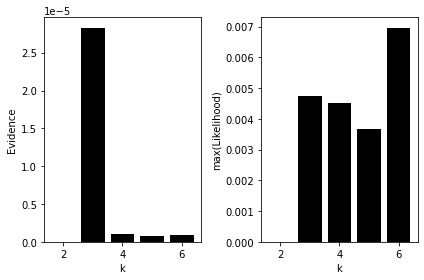

In [7]:
burn_in = 2000

likelihood_list = [np.array(sampler_list[0].accept_likelihood)[burn_in:],
                   np.array(sampler_list[1].accept_likelihood)[burn_in:],
                   np.array(sampler_list[2].accept_likelihood)[burn_in:],
                   np.array(sampler_list[3].accept_likelihood)[burn_in:],
                   np.array(sampler_list[4].accept_likelihood)[burn_in:]
                  ]

evidence_list = [1./np.mean(1./likelihood_list[0]),
                 1./np.mean(1./likelihood_list[1]),
                 1./np.mean(1./likelihood_list[2]),
                 1./np.mean(1./likelihood_list[3]),
                 1./np.mean(1./likelihood_list[4])
                ]

fig_li_ev, ax_li_ev = plt.subplots(1,2)
for i in range(5):
    sampler           = sampler_list[i]
    evidence          = evidence_list[i]
    likelihood        = np.max(likelihood_list[i])
    ax_li_ev[0].bar(i+2, evidence, color="black")
    ax_li_ev[1].bar(i+2, likelihood, color="black")
    
ax_li_ev[0].set_xlabel("k")
ax_li_ev[0].set_ylabel("Evidence")
ax_li_ev[1].set_xlabel("k")
ax_li_ev[1].set_ylabel("max(Likelihood)")

fig_li_ev.tight_layout()
fig_li_ev.show()
print("Bayes Factor M3/M2:", evidence_list[1]/evidence_list[0])
print("Bayes Factor M3/M4:", evidence_list[1]/evidence_list[2])
print("Bayes Factor M3/M5:", evidence_list[1]/evidence_list[3])
print("Bayes Factor M3/M6:", evidence_list[1]/evidence_list[4])

## 6.) Model Inference Using Across-model sampling with RJ-MCMC

Ok, so we have seen that we can recover the correct model by computing the evidence for each single model. But we need lots of sampling (100000 steps) in order to get converged results. Also, we need to carry out sampling for each model seperately. To be fair, there are probably more efficent sampling algorithms than MH for this kind of inference problem. Also, we did not optimize the hyperparameters. Nonetheless, there is an elegant way to get the correct answer with much less sampling effort, called Reversible Jump MCMC (RJ-MCMC). Instead of explicitly sampling the posterior of each individual model, one can also sample over a posterior that lives on the parameter space of different models simultaniously. This approach is called across-model sampling and effectively samples from the distribution $(k,\theta_k) \sim p(k, \theta_k | Y)$. The Markov Chain will then have spent time in the different models in proportion to their model evidence. This is especially efficient for models that are nested, i.e. when parameters from one model can be carried over to another model.

### Just another way of Metropolis-Hasting'ing

How does RJ-MCMC work? It is essentially a variation of standard MH sampling. Because all we will do in RJ-MCMC is just normal MCMC but with proposal and target distributions (i.e. the posterior distribution) living on different (sub)spaces with different dimensionality (this point will become clear later)! The general acceptance probability for RJ-MCMC is (note that we omit $\sigma$ here for the sake of clarity):

\begin{equation}\label{eq:RjmcmcAcceptance}
\alpha(k, \theta_{k}, k', \theta'_{k'}) = min\Bigg(1, { p(k', \theta'_{k'}|Y) q(k, \theta_{k}, k', \theta'_{k'})
                                                  \over p(k, \theta_{k}|Y) q(k', \theta'_{k'},k, \theta_{k}) } \Bigg)
\end{equation}

This is really not so much different than the acceptance probability for regular MH (see eq. \ref{eq:AcceptanceProbability})! The only difference is that now we sample from the joint posterior distribution $p(k, \theta_k | Y)$ and propose from the joint distribution $q(k, \theta_k, \cdot)$. The posterior distribution $p(k, \theta|Y)$ is computed similarly as the one for within-model sampling (see eq. \ref{eq:BayesEquation}). However, the proposal distribution  will be computed in a different manner in order to reflect the difference in dimensionalty (if any) between proposal and target distribution. Furthermore, the general MH algorithm will be slightly adapted as follows:

\begin{enumerate}
\item Generate a new state *within* $\theta'_k$ from a proposal distribution $q_2(\theta^{(t)_k}, \theta'_k)$ (yet to be defined).
\item Propose an across model move according to $q_1(k^{(t)}, k')$ (yet to be defined).
\item Generate an updated parameter $\theta'_{k'}$ according to the within and across model move.
\item Evaluate the posterior distribution according to eq. \ref{eq:RjmcmcAcceptance} and standard MH rejection/acceptance scheme.
\end{enumerate}

The following two paragraphs will outline two general ways to implement this algorithm.

#### The general across-model move

For a proposal to jump from model $k$ to $k+1$ (let's call this an expansion move, since we "expand" our model), the proposal probability can be stated as

\begin{equation*}
q(k+1, \theta_{k+1},k, \theta_{k}) = q_1(k+1, k) q_2(\theta_{k+1}, \theta_{k})
\end{equation*}

The parameter proposal can be further marginalized as 

\begin{equation*}
q_2(\theta_{k+1}, \theta_{k}) = q^{(k+1)}_2(\theta_{k+1}| \theta_{k}) q^{(1:k)}_2(\theta_{k})
\end{equation*}

Here, $q^{(k+1)}_2)$ is the proposal conditional probability for the $k+1$ element in the parameter vector. The $q^{(1:k)}_2$ probability accounts for the proposal of the first $k$ elements in the parameter vector, this is the regular MH proposal probability.

Conversly, the marginalized parameter proposal probability for an across model move from $k+1$ to $k$ (i.e. a contraction move) is (note that we just keep the $(1:k)$ parameters):

\begin{equation*}
q_2(\theta_{k}, \theta_{k+1}) = q^{(1:k)}_2(\theta_{k+1})
\end{equation*}

If we combine the above considerations with eq. \ref{eq:RjmcmcAcceptance}, we get an acceptance probability for an expansion move (assuming symmetric proposal $q^{(1:k)}_2(\cdot)$ ):

\begin{equation}\label{eq:RjmcmcAcceptance_GeneralCaseExpansion}
\alpha(k, \theta_{k}, k+1, \theta_{k+1}) = min\Bigg(1, { p(k+1, \theta_{k+1}|Y) q_1(k, k+1)
                                                   \over p(k, \theta_{k}|Y) q_1(k+1, k) q^{(k+1)}_2(\theta_{k+1}|                                                              \theta_{k})
                                                   }
                                              \Bigg)
\end{equation}

Note that the acceptance probability for the contraction move is just the inverse of eq. \ref{eq:RjmcmcAcceptance_GeneralCaseExpansion}.

The across model moves introduced so far sample the additional element in the parameter vector during an expansion move $u = \theta^{(k+1)}_{k+1}$ from $u \sim q^{(k+1)}_2(\theta_{k+1}| \cdot)$. While doing this, we ensured to have no overall change in dimensionality for an expansion move and its corresponding contraction move. That is, we imposed the following important boundary condition to any across model proposal ($dim(u)$ is the number of elements of vector $u$, including zero):

\begin{equation}\label{eq:BoundaryConditionMove}
k + dim(u) = k' + dim(u')
\end{equation}

#### Using deterministic functions to inform across model moves

In many cases, it is beneficial to use an informative deterministic function after the parameter proposal step in order to transform the proposed parameter to something reasonable. This concept can be incorporated into RJ-MCMC, as long as this function has a proper inverse function, so that we can propose the reverse move. Then, an expansion move (after drawing $u$) is set to 

\begin{equation*}
\theta_{k+1} = h(\theta_k, u) = (\theta_k, g(u))
\end{equation*}

whereas the corresponding contraction move is attempted according to ($h'$ and $g'$ are the reversed functions)

\begin{equation*}
(\theta_{k}, u) = h'(\theta_{k+1}) = (\theta^{(1:k)}_{k+1}, g'(\theta^{(k)}_{k+1}))
\end{equation*}

If we use a deterministic function to manipulate the integration variable (remember that we still try to solve eq. \ref{eq:DetailedBalanceIntegrated}), we need a Jacobian factor $|J|$ to account for the change of variables in the integration variable. The expansion move then is

\begin{equation}\label{eq:RjmcmcAcceptance_DeterministicCaseExpansion}
\alpha(k, \theta_{k}, k+1, \theta_{k+1}) = min\Bigg(1, { p(k+1, \theta_{k+1}|Y) q_1(k, k+1) q_2(u_k)
                                                   \over p(k, \theta_{k}|Y) q_1(k+1, k) q_2(u_{k+1})} 
                                                   \Big| {\partial(h'(\theta_{k+1})) \over \partial(\theta_k, u_k)}                                                      \Big|
                                              \Bigg)
\end{equation}

Similarly to the general case, the acceptance probability for the contraction move is obtained from the reverse of eq. \ref{eq:RjmcmcAcceptance_DeterministicCaseExpansion}.

Note how the Jacobian will be unity after setting $h(\theta_k, u) = (\theta_k, u)$ and $h'(\theta_{k+1}) = (\theta^{(1:k)}_{k+1})$ and we obtain the result of the general case (eq. \ref{eq:RjmcmcAcceptance_GeneralCaseExpansion}).

### Jump into the Sampling

The code block in the next cell will execute RJ-MCMC sampling with the "general" case (see eq. \ref{eq:RjmcmcAcceptance_GeneralCaseExpansion}). Note that parameters for an expansion move are proposed according to

\begin{equation}\label{eq:PropagationExpansion}
a_{k+1}' = a_k^{(t)} + w_k
\end{equation}

\begin{equation*}
w_k \sim \mathcal{N}(0, s_e)
\end{equation*}

The parameter $s_e$ controls the width of the proposal distribution $q_2(\theta^{(t)_k}, \theta'_{k+1})$. The implementation below can also use deterministic type moves (set the variable 'dete' to 'True') by using $g(u) = s_e exp(u)$ and $g'(a_{k+1}) = log(a_{k+1})-log(s_e)$.

## Reading

* Waagepetersen, R., & Sorensen, D. (2001). A tutorial on reversible jump MCMC with a view toward applications in QTL-mapping. International Statistical Review, 69(1), 49–61.
* Green, P. J. (1995). Reversible jump Markov chain monte carlo computation and Bayesian model determination. Biometrika, 82(4), 711–732.
* Hastie, D. I., & Green, P. J. (2012). Model choice using reversible jump Markov chain Monte Carlo. Statistica Neerlandica, 66(3), 309–338.
* Godsill, S. J. (2001). On the relationship between markov chain monte carlo methods for model uncertainty. Journal of Computational and Graphical Statistics, 10(2), 230–248.

In [8]:
### This is our step width 's'
step_width  = 0.05
### This is our prior width for the inverse gamma distribution
sigma_width = 2.0
### This is our reference that defines the boundaries on 
### parameter prior.
p_ref       = np.array([0., 6])
### This is the initial value of the standard deviation.
### We will use the same value for each MH run
sigma0      = 0.1
### This is a parameter that controls the mapping for the
### dimension jumping
se = 1.0
### Use deterministic sampling
dete = False

### This is a list of initial parameter vectors. They are of
### varying length, going from 2 up to 6 parameters.
p0_list = [p[:2] + 1.0 * np.random.random(2), 
           p     + 1.0 * np.random.random(p.shape),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0])),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0, 1.0])),
           np.concatenate((p + 1.0 * np.random.random(p.shape),[1.0, 1.0, 1.0]))
           ]

### Let's loop over some models and see how that
### changes the Bayesian quantities and the parameters
lazy_results = list()
def worker(sampler, *args):
    sampler.run(*args)
    return sampler
for p0 in p0_list:
    sampler = MH_sampler(step_width,
                         sigma_width,
                         p_ref,
                         x,
                         y,
                         fourier_series)

    ### This is samplig by using the general RJ-MCMC
    lazy_result = dask.delayed(worker)(sampler, p0, sigma0, 10000, se, True, dete)
    lazy_results.append(lazy_result)
sampler_list_rj = list(dask.compute(*lazy_results))

### Analysis of the RJ-MCMC Sampling

Note how we only need 1/10 of the sampling from the previous example where we had to sample each modell individually. If we closely look at the trajectories below, we see that even a much smaller number of sampling steps would have been sufficient to arrive at the correct model. However, we also see that although the correct model is found early for most intitial conditions, the $-ln(posterior)$ still decreases and in real live we likely want to have more sampling in order to ensure we have enough within-model samples. Also, it is important to realize that the RJ-MCMC sampler arrives at the correct model independent of the starting conditions. This is great!

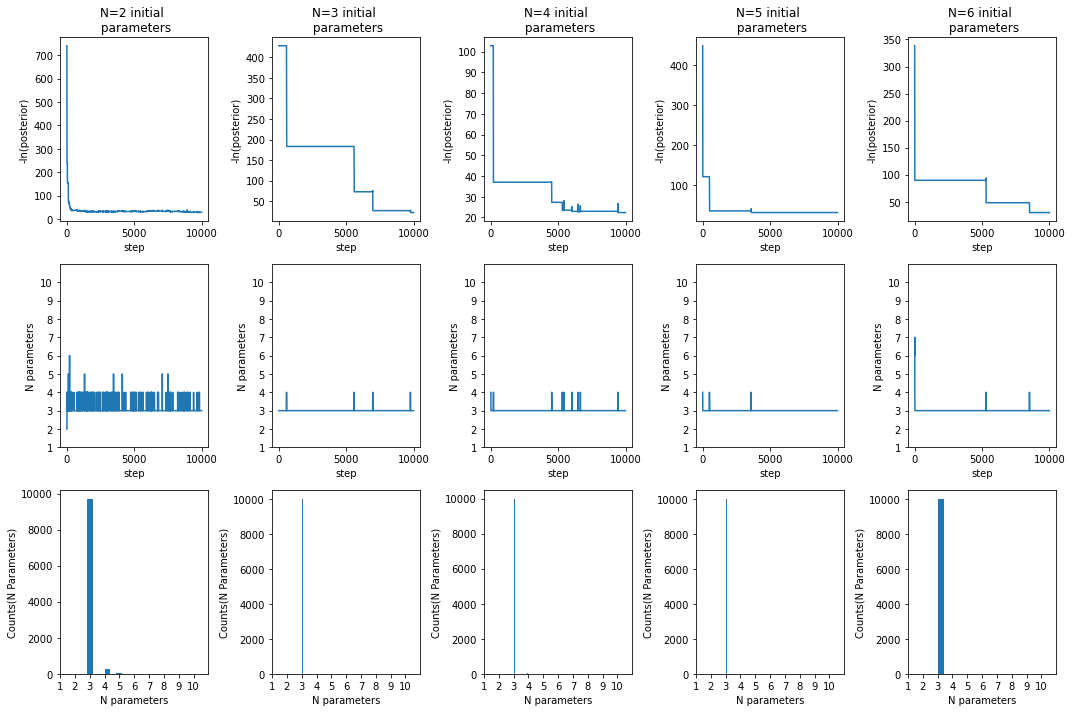

In [9]:
fig_traj, ax_traj = plt.subplots(3, 5, figsize=(15,10))
for i in range(5):
    sampler          = sampler_list_rj[i]
    accept_posterior = sampler.accept_posterior
    accept_dim       = sampler.accept_dim

    ax_traj[0][i].plot(-np.log(accept_posterior))
    ax_traj[0][i].set_title(f"N={i+2} initial \n parameters")
    ax_traj[0][i].set_ylabel("-ln(posterior)")
    ax_traj[0][i].set_xlabel("step")

    ax_traj[1][i].plot(accept_dim)
    ax_traj[1][i].set_ylabel("N parameters")
    ax_traj[1][i].set_xlabel("step")
    ax_traj[1][i].set_yticks(list(range(1,11)))
    ax_traj[1][i].set_ylim(1,11)
    
    ax_traj[2][i].hist(accept_dim)
    ax_traj[2][i].set_ylabel("Counts(N Parameters)")
    ax_traj[2][i].set_xlabel("N parameters")
    ax_traj[2][i].set_xticks(list(range(1,11)))
    ax_traj[2][i].set_xlim(1,11)

fig_traj.tight_layout()
fig_traj.show()